#  <center> BHAAV VAACHAK <center>

##### Aditya Agarwal
##### Abhijeet
##### Abhilash Sharma
##### Moradabad Institute of Technology, Moradabad ( B.Tech, CSE 2024)
##### 3rd year, session 2022-23

#### Datasets used in this project

* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto emotional speech set (Tess)

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## DataSET Loading


In [2]:
# Paths for data.
Ravdess = r"C:\Users\adity\Downloads\RAVDESS\audio_speech_actors_01-24"
Crema = r"C:\Users\adity\Downloads\CREMA-D\AudioWAV"
Tess = r"C:\Users\adity\Downloads\TESS\TESS Toronto emotional speech set data\TESS Toronto emotional speech set data"
Savee = r"C:\Users\adity\Downloads\SAVEE\ALL"

##  <center> 1. Ravdess Dataframe <center>

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + '\\'+ dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess +'/'+ dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,C:\Users\adity\Downloads\RAVDESS\audio_speech_...
1,neutral,C:\Users\adity\Downloads\RAVDESS\audio_speech_...
2,neutral,C:\Users\adity\Downloads\RAVDESS\audio_speech_...
3,neutral,C:\Users\adity\Downloads\RAVDESS\audio_speech_...
4,calm,C:\Users\adity\Downloads\RAVDESS\audio_speech_...


## <center>2. Crema DataFrame</center>

In [4]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + '\\' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,C:\Users\adity\Downloads\CREMA-D\AudioWAV\1001...
1,disgust,C:\Users\adity\Downloads\CREMA-D\AudioWAV\1001...
2,fear,C:\Users\adity\Downloads\CREMA-D\AudioWAV\1001...
3,happy,C:\Users\adity\Downloads\CREMA-D\AudioWAV\1001...
4,neutral,C:\Users\adity\Downloads\CREMA-D\AudioWAV\1001...


##  <center> 3. TESS dataset <center>

In [12]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess +'\\'+ dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,angry,C:\Users\adity\Downloads\TESS\TESS Toronto emo...
1,angry,C:\Users\adity\Downloads\TESS\TESS Toronto emo...
2,angry,C:\Users\adity\Downloads\TESS\TESS Toronto emo...
3,angry,C:\Users\adity\Downloads\TESS\TESS Toronto emo...
4,angry,C:\Users\adity\Downloads\TESS\TESS Toronto emo...


##  <center> 4. CREMA-D dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [10]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + '\\' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,angry,C:\Users\adity\Downloads\SAVEE\ALL\DC_a01.wav
1,angry,C:\Users\adity\Downloads\SAVEE\ALL\DC_a02.wav
2,angry,C:\Users\adity\Downloads\SAVEE\ALL\DC_a03.wav
3,angry,C:\Users\adity\Downloads\SAVEE\ALL\DC_a04.wav
4,angry,C:\Users\adity\Downloads\SAVEE\ALL\DC_a05.wav


In [6]:
#creating combined dataframe
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path

,Emotions,Path
0,neutral,C:\Users\adity\Downloads\RAVDESS\audio_speech_...
1,neutral,C:\Users\adity\Downloads\RAVDESS\audio_speech_...
2,neutral,C:\Users\adity\Downloads\RAVDESS\audio_speech_...
3,neutral,C:\Users\adity\Downloads\RAVDESS\audio_speech_...
4,calm,C:\Users\adity\Downloads\RAVDESS\audio_speech_...
...,...,...
1435,surprise,C:\Users\adity\Downloads\RAVDESS\audio_speech_...
1436,surprise,C:\Users\adity\Downloads\RAVDESS\audio_speech_...
1437,surprise,C:\Users\adity\Downloads\RAVDESS\audio_speech_...
1438,surprise,C:\Users\adity\Downloads\RAVDESS\audio_speech_...


## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

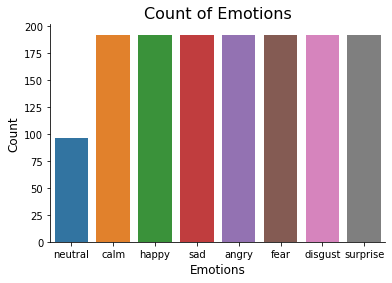

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

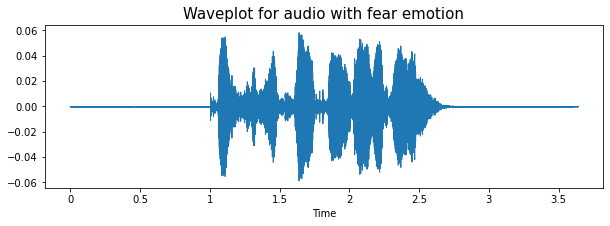

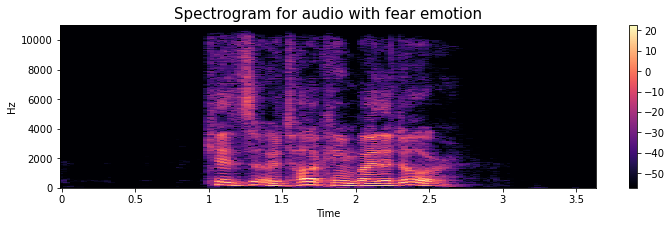

In [9]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

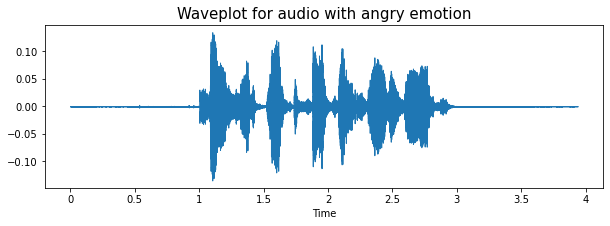

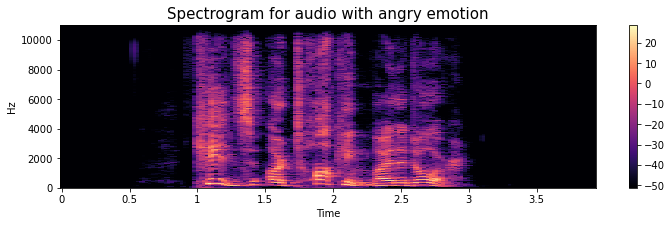

In [10]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

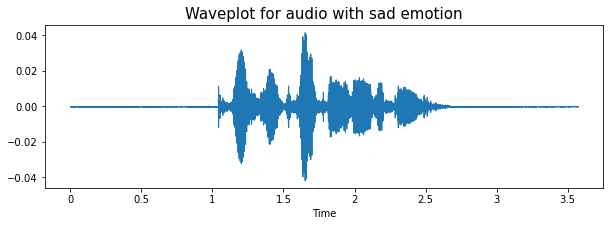

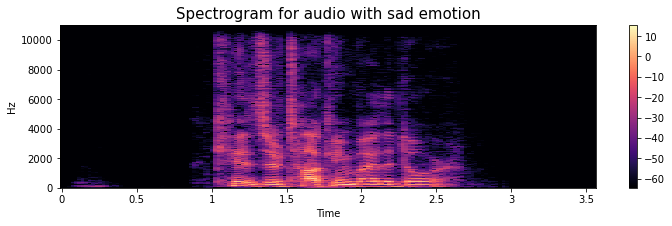

In [11]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

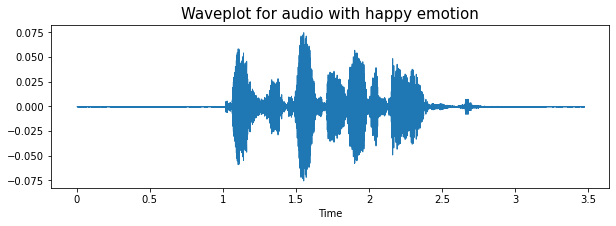

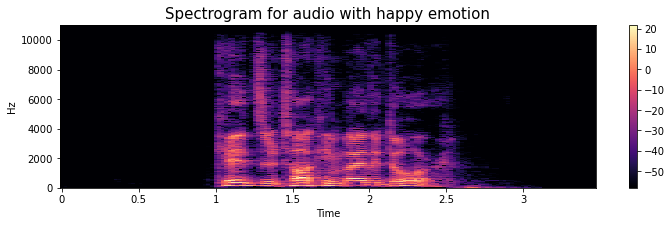

In [12]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [13]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

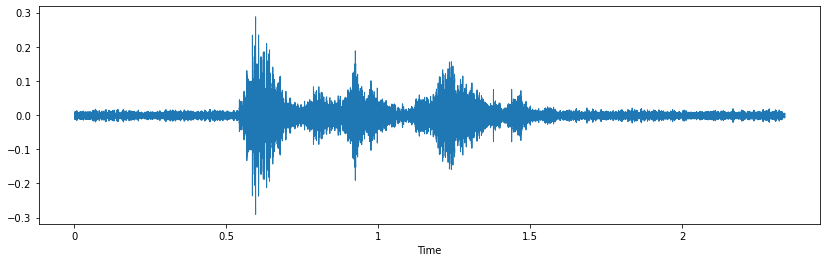

In [25]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

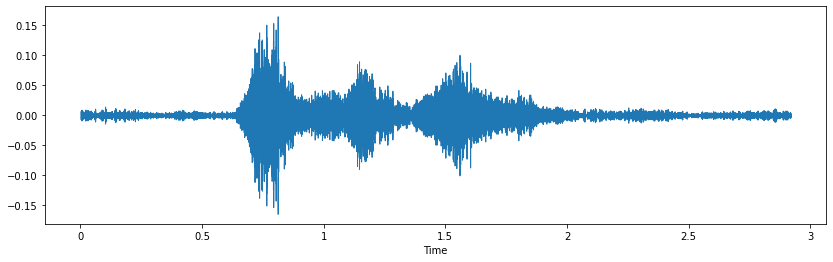

In [27]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

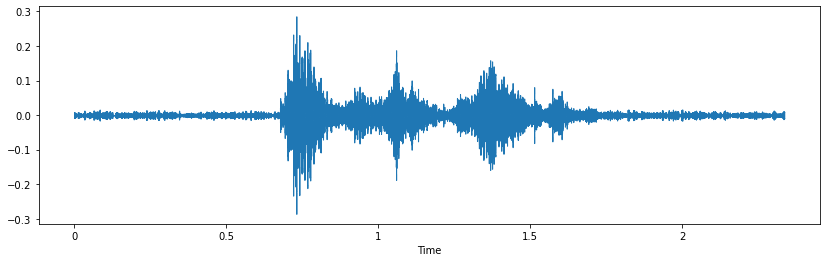

In [28]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

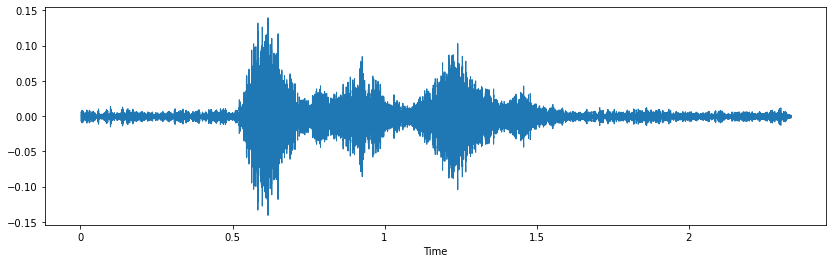

In [29]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction

The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)


- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [14]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [15]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [16]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [17]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.283226,0.739174,0.760110,0.738748,0.712194,0.687986,0.667279,0.694000,0.742275,0.762594,...,4.312694e-06,3.293364e-06,2.149553e-06,2.260914e-06,4.562520e-06,4.985617e-06,1.324619e-06,1.469305e-07,3.053402e-09,neutral
1,0.293046,0.756509,0.806558,0.793267,0.788369,0.786795,0.727330,0.656570,0.697488,0.750586,...,1.395839e-05,1.253094e-05,1.162507e-05,1.165179e-05,1.403449e-05,1.438488e-05,1.051672e-05,9.493375e-06,9.146622e-06,neutral
2,0.181467,0.629995,0.730929,0.743651,0.680889,0.670727,0.673700,0.669033,0.709932,0.745144,...,8.582505e-07,9.570446e-07,7.741540e-07,5.212421e-07,3.252106e-07,4.883136e-07,2.353670e-07,2.240905e-08,9.753157e-11,neutral
3,0.254530,0.676571,0.724970,0.725722,0.668644,0.645344,0.671471,0.631493,0.681748,0.709889,...,6.987414e-06,7.038922e-06,6.659573e-06,6.937638e-06,1.117492e-05,5.767251e-06,2.024577e-06,1.944936e-07,2.701240e-09,neutral
4,0.303349,0.749604,0.795049,0.811974,0.770629,0.765815,0.756113,0.652309,0.676002,0.718148,...,4.941513e-05,4.751048e-05,4.528707e-05,4.843979e-05,5.160237e-05,4.834570e-05,4.583254e-05,4.146789e-05,3.949519e-05,neutral


* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [18]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [19]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [20]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [21]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [22]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

## Modelling

In [23]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [24]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 8s 134ms/step - loss: 1.9829 - accuracy: 0.1960 - val_loss: 1.8684 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 6s 125ms/step - loss: 1.9218 - accuracy: 0.2407 - val_loss: 1.8277 - val_accuracy: 0.3361 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 6s 126ms/step - loss: 1.8721 - accuracy: 0.2679 - val_loss: 1.7577 - val_accuracy: 0.3231 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 7s 128ms/step - loss: 1.8296 - accuracy: 0.2870 - val_loss: 1.7388 - val_accuracy: 0.3759 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 6s 125ms/step - loss: 1.7710 - accuracy: 0.3096 - val_loss: 1.6648 - val_accuracy: 0.3602 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 6s 126ms/step - loss: 1.7241 - accuracy: 0.3330 - val_loss: 1.5893 - val_accuracy: 0.4019 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 7s 141ms/step - lo

34/34 [==============================] - 1s 18ms/step - loss: 1.3090 - accuracy: 0.6454
Accuracy of our model on test data :  64.5370364189148 %


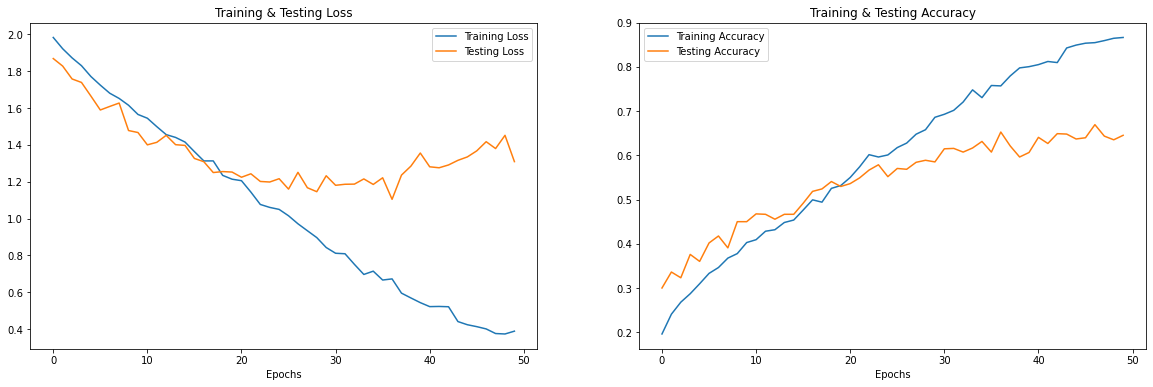

In [25]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [26]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 1s 17ms/step


In [27]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,angry,angry
2,happy,fear
3,neutral,calm
4,angry,angry
5,surprise,surprise
6,fear,fear
7,fear,happy
8,fear,fear
9,neutral,sad


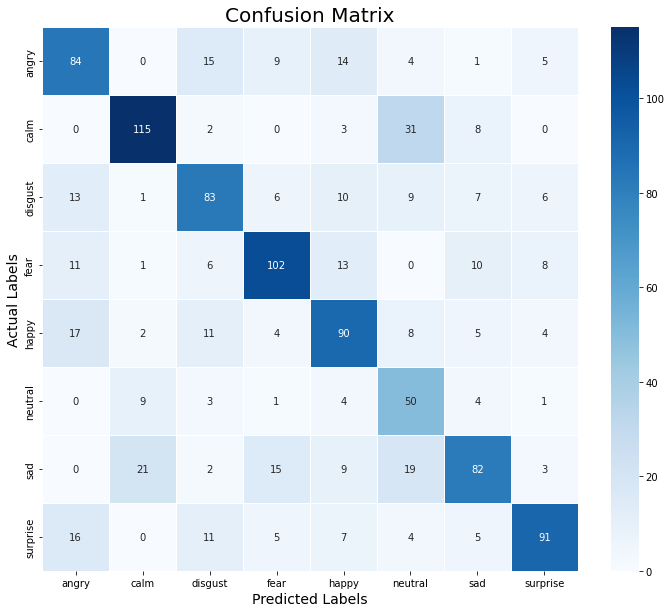

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.60      0.64      0.62       132
        calm       0.77      0.72      0.75       159
     disgust       0.62      0.61      0.62       135
        fear       0.72      0.68      0.70       151
       happy       0.60      0.64      0.62       141
     neutral       0.40      0.69      0.51        72
         sad       0.67      0.54      0.60       151
    surprise       0.77      0.65      0.71       139

    accuracy                           0.65      1080
   macro avg       0.64      0.65      0.64      1080
weighted avg       0.66      0.65      0.65      1080



- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.

### This is all i wanna do in this project. Hope you guyz like this. 
### If you like the kernel make sure to upvote it please :-)